# Setup

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, row_number
from pyspark.sql.window import Window

spark = (SparkSession.builder.appName("cs544")
         .master("spark://main:7077")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", "hdfs://main:9000/user/hive/warehouse")
         .enableHiveSupport()
         .getOrCreate())

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/03/22 14:00:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# ! wget https://pages.cs.wisc.edu/~harter/cs639/data/sf.zip
# ! unzip sf.zip

In [3]:
!hdfs dfs -cp sf.csv hdfs://main:9000/sf.csv

In [4]:
df = (spark.read.format("csv")
    .option("header", True)
    .option("inferSchema", True)
    .load("hdfs://main:9000/sf.csv"))
columns = [col(c).alias(c.replace(" ", "")) for c in df.columns]
df.select(columns).write.format("parquet").mode("overwrite").save("hdfs://main:9000/sf.parquet")

23/03/22 14:02:13 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


## Lecture Part 1: Views and Tables

In [5]:
df = spark.read.format("parquet").load("hdfs://main:9000/sf.parquet")

In [6]:
# creating a view doesn't compute anything, it describes how to compute it as needed
# df.createTempView("calls")
df.createOrReplaceTempView("calls")

In [11]:
spark.sql("SHOW TABLES").show()   # shows both views and tables

+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
|         |    calls|       true|
+---------+---------+-----------+



In [13]:
df.limit(10).toPandas()

,CallNumber,UnitID,IncidentNumber,CallType,CallDate,WatchDate,ReceivedDtTm,EntryDtTm,DispatchDtTm,ResponseDtTm,...,CallTypeGroup,NumberofAlarms,UnitType,Unitsequenceincalldispatch,FirePreventionDistrict,SupervisorDistrict,Neighborhooods-AnalysisBoundaries,RowID,case_location,AnalysisNeighborhoods
0,201340825,T06,20055834,Other,05/13/2020,05/13/2020,05/13/2020 08:51:30 AM,05/13/2020 08:51:30 AM,05/13/2020 08:54:56 AM,05/13/2020 08:55:10 AM,...,Alarm,1,TRUCK,1,2,8,Mission,201340825-T06,POINT (-122.42251458613262 37.770727334245194),20
1,201241707,FB3,20052084,Outside Fire,05/03/2020,05/03/2020,05/03/2020 01:46:02 PM,05/03/2020 01:46:02 PM,05/03/2020 01:46:11 PM,05/03/2020 01:47:41 PM,...,Alarm,1,SUPPORT,2,1,3,Financial District/South Beach,201241707-FB3,POINT (-122.3946511276673 37.79530574375478),8
2,201083222,AM118,20045948,Medical Incident,04/17/2020,04/17/2020,04/17/2020 09:19:43 PM,04/17/2020 09:19:43 PM,04/17/2020 09:21:10 PM,04/17/2020 09:21:55 PM,...,Non Life-threatening,1,PRIVATE,2,2,6,South of Market,201083222-AM118,POINT (-122.41071806030364 37.778959763358266),34
3,201160160,54,20048802,Medical Incident,04/25/2020,04/24/2020,04/25/2020 01:39:37 AM,04/25/2020 01:41:00 AM,04/25/2020 01:42:09 AM,04/25/2020 01:42:22 AM,...,Potentially Life-Threatening,1,MEDIC,1,2,6,Tenderloin,201160160-54,POINT (-122.41632744176792 37.78244849821827),36
4,201382742,70,20057634,Medical Incident,05/17/2020,05/17/2020,05/17/2020 06:16:44 PM,05/17/2020 06:19:46 PM,05/17/2020 06:20:39 PM,05/17/2020 06:20:42 PM,...,Non Life-threatening,1,MEDIC,1,3,6,Mission Bay,201382742-70,POINT (-122.39820071397247 37.772033503746634),4
5,201471465,82,20061098,Medical Incident,05/26/2020,05/26/2020,05/26/2020 11:28:57 AM,05/26/2020 11:32:34 AM,05/26/2020 11:46:47 AM,05/26/2020 11:46:47 AM,...,Potentially Life-Threatening,1,MEDIC,4,7,1,Golden Gate Park,201471465-82,POINT (-122.5004598282247 37.76815687556086),12
6,201323381,94,20055383,Medical Incident,05/11/2020,05/11/2020,05/11/2020 10:58:24 PM,05/11/2020 11:00:56 PM,05/11/2020 11:01:34 PM,05/11/2020 11:01:52 PM,...,Potentially Life-Threatening,1,MEDIC,2,2,6,Mission,201323381-94,POINT (-122.40800720584919 37.76924401107554),20
7,201413221,QRV1,20058866,Medical Incident,05/20/2020,05/20/2020,05/20/2020 08:17:16 PM,05/20/2020 08:17:16 PM,05/20/2020 08:17:30 PM,05/20/2020 08:17:33 PM,...,Potentially Life-Threatening,1,SUPPORT,1,2,6,Tenderloin,201413221-QRV1,POINT (-122.41906982202991 37.77843736682197),36
8,201282947,AM118,20053839,Medical Incident,05/07/2020,05/07/2020,05/07/2020 05:59:37 PM,05/07/2020 06:03:16 PM,05/07/2020 06:04:50 PM,05/07/2020 06:05:25 PM,...,Non Life-threatening,1,PRIVATE,2,None,6,Treasure Island,201282947-AM118,POINT (-122.36513827228869 37.81052072252062),37
9,201251640,E29,20052477,Outside Fire,05/04/2020,05/04/2020,05/04/2020 12:47:36 PM,05/04/2020 12:48:49 PM,05/04/2020 12:48:53 PM,05/04/2020 12:50:17 PM,...,Fire,1,ENGINE,1,2,10,Potrero Hill,201251640-E29,POINT (-122.40556651195942 37.76330275793136),20


In [15]:
col("CallType")

Column<'CallType123'>

In [17]:
df.where(col("CallType").startswith("Odor"))

DataFrame[CallNumber: int, UnitID: string, IncidentNumber: int, CallType: string, CallDate: string, WatchDate: string, ReceivedDtTm: string, EntryDtTm: string, DispatchDtTm: string, ResponseDtTm: string, OnSceneDtTm: string, TransportDtTm: string, HospitalDtTm: string, CallFinalDisposition: string, AvailableDtTm: string, Address: string, City: string, ZipcodeofIncident: int, Battalion: string, StationArea: string, Box: string, OriginalPriority: string, Priority: string, FinalPriority: int, ALSUnit: boolean, CallTypeGroup: string, NumberofAlarms: int, UnitType: string, Unitsequenceincalldispatch: int, FirePreventionDistrict: string, SupervisorDistrict: string, Neighborhooods-AnalysisBoundaries: string, RowID: string, case_location: string, AnalysisNeighborhoods: int]

In [16]:
df.where(col("CallType").startswith("Odor")).count()

13373

In [20]:
df.where(col("CallType").startswith("Odor")).write.saveAsTable("stinky", mode="overwrite")

23/03/22 15:11:25 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
23/03/22 15:11:26 WARN HiveConf: HiveConf of name hive.internal.ss.authz.settings.applied.marker does not exist
23/03/22 15:11:26 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
23/03/22 15:11:26 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist


In [22]:
spark.sql("SHOW TABLES").show()

+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
|  default|   stinky|      false|
|         |    calls|       true|
+---------+---------+-----------+



In [23]:
!hdfs dfs -ls hdfs://main:9000/user/hive/warehouse

Found 1 items
drwxr-xr-x   - root supergroup          0 2023-03-22 15:11 hdfs://main:9000/user/hive/warehouse/stinky


In [24]:
!hdfs dfs -ls hdfs://main:9000/user/hive/warehouse/stinky

Found 7 items
-rw-r--r--   3 root supergroup          0 2023-03-22 15:11 hdfs://main:9000/user/hive/warehouse/stinky/_SUCCESS
-rw-r--r--   3 root supergroup     334097 2023-03-22 15:11 hdfs://main:9000/user/hive/warehouse/stinky/part-00000-e5cc9daf-c4bb-45b3-a390-4d96b7290cf8-c000.snappy.parquet
-rw-r--r--   3 root supergroup     370361 2023-03-22 15:11 hdfs://main:9000/user/hive/warehouse/stinky/part-00001-e5cc9daf-c4bb-45b3-a390-4d96b7290cf8-c000.snappy.parquet
-rw-r--r--   3 root supergroup     173319 2023-03-22 15:11 hdfs://main:9000/user/hive/warehouse/stinky/part-00002-e5cc9daf-c4bb-45b3-a390-4d96b7290cf8-c000.snappy.parquet
-rw-r--r--   3 root supergroup     209072 2023-03-22 15:11 hdfs://main:9000/user/hive/warehouse/stinky/part-00003-e5cc9daf-c4bb-45b3-a390-4d96b7290cf8-c000.snappy.parquet
-rw-r--r--   3 root supergroup     138599 2023-03-22 15:11 hdfs://main:9000/user/hive/warehouse/stinky/part-00004-e5cc9daf-c4bb-45b3-a390-4d96b7290cf8-c000.snappy.parquet
-rw-r--r--   3 root

In [25]:
df.where(col("CallType").startswith("Odor")).rdd.getNumPartitions()

6

In [27]:
spark.sql("""
SELECT *
FROM calls
LIMIT 5
""").toPandas()

,CallNumber,UnitID,IncidentNumber,CallType,CallDate,WatchDate,ReceivedDtTm,EntryDtTm,DispatchDtTm,ResponseDtTm,...,CallTypeGroup,NumberofAlarms,UnitType,Unitsequenceincalldispatch,FirePreventionDistrict,SupervisorDistrict,Neighborhooods-AnalysisBoundaries,RowID,case_location,AnalysisNeighborhoods
0,201340825,T06,20055834,Other,05/13/2020,05/13/2020,05/13/2020 08:51:30 AM,05/13/2020 08:51:30 AM,05/13/2020 08:54:56 AM,05/13/2020 08:55:10 AM,...,Alarm,1,TRUCK,1,2,8,Mission,201340825-T06,POINT (-122.42251458613262 37.770727334245194),20
1,201241707,FB3,20052084,Outside Fire,05/03/2020,05/03/2020,05/03/2020 01:46:02 PM,05/03/2020 01:46:02 PM,05/03/2020 01:46:11 PM,05/03/2020 01:47:41 PM,...,Alarm,1,SUPPORT,2,1,3,Financial District/South Beach,201241707-FB3,POINT (-122.3946511276673 37.79530574375478),8
2,201083222,AM118,20045948,Medical Incident,04/17/2020,04/17/2020,04/17/2020 09:19:43 PM,04/17/2020 09:19:43 PM,04/17/2020 09:21:10 PM,04/17/2020 09:21:55 PM,...,Non Life-threatening,1,PRIVATE,2,2,6,South of Market,201083222-AM118,POINT (-122.41071806030364 37.778959763358266),34
3,201160160,54,20048802,Medical Incident,04/25/2020,04/24/2020,04/25/2020 01:39:37 AM,04/25/2020 01:41:00 AM,04/25/2020 01:42:09 AM,04/25/2020 01:42:22 AM,...,Potentially Life-Threatening,1,MEDIC,1,2,6,Tenderloin,201160160-54,POINT (-122.41632744176792 37.78244849821827),36
4,201382742,70,20057634,Medical Incident,05/17/2020,05/17/2020,05/17/2020 06:16:44 PM,05/17/2020 06:19:46 PM,05/17/2020 06:20:39 PM,05/17/2020 06:20:42 PM,...,Non Life-threatening,1,MEDIC,1,3,6,Mission Bay,201382742-70,POINT (-122.39820071397247 37.772033503746634),4


In [28]:
spark.sql("""
SELECT *
FROM stinky
LIMIT 5
""").toPandas()

,CallNumber,UnitID,IncidentNumber,CallType,CallDate,WatchDate,ReceivedDtTm,EntryDtTm,DispatchDtTm,ResponseDtTm,...,CallTypeGroup,NumberofAlarms,UnitType,Unitsequenceincalldispatch,FirePreventionDistrict,SupervisorDistrict,Neighborhooods-AnalysisBoundaries,RowID,case_location,AnalysisNeighborhoods
0,31380322,E19,3039579,Odor (Strange / Unknown),05/18/2003,05/18/2003,05/18/2003 06:06:07 PM,05/18/2003 06:07:29 PM,05/18/2003 06:08:15 PM,None,...,None,1,ENGINE,1,8,7,Lakeshore,031380322-E19,POINT (-122.484903847655 37.720566578193),16
1,30630341,B04,3018168,Odor (Strange / Unknown),03/04/2003,03/04/2003,03/04/2003 03:15:45 PM,03/04/2003 03:18:48 PM,03/04/2003 03:19:27 PM,03/04/2003 03:19:38 PM,...,None,1,CHIEF,2,4,3,Nob Hill,030630341-B04,POINT (-122.418012422783 37.789883351367),21
2,30520027,B03,3014868,Odor (Strange / Unknown),02/21/2003,02/20/2003,02/21/2003 02:16:47 AM,02/21/2003 02:17:59 AM,02/21/2003 02:18:41 AM,02/21/2003 02:19:56 AM,...,None,1,CHIEF,3,2,6,Tenderloin,030520027-B03,POINT (-122.415737767164 37.780721312022),36
3,30130052,T02,3003693,Odor (Strange / Unknown),01/13/2003,01/12/2003,01/13/2003 06:22:42 AM,01/13/2003 06:25:16 AM,01/13/2003 06:25:33 AM,01/13/2003 06:28:48 AM,...,None,1,TRUCK,3,1,3,Chinatown,030130052-T02,POINT (-122.405288399326 37.796909057545),6
4,30130024,T03,3003668,Odor (Strange / Unknown),01/13/2003,01/12/2003,01/13/2003 02:50:47 AM,01/13/2003 02:53:13 AM,01/13/2003 02:54:24 AM,01/13/2003 02:56:19 AM,...,None,1,TRUCK,1,1,3,Tenderloin,030130024-T03,POINT (-122.412761859687 37.786836359226),36


In [29]:
# table/view to DataFrame
spark.table("stinky")

DataFrame[CallNumber: int, UnitID: string, IncidentNumber: int, CallType: string, CallDate: string, WatchDate: string, ReceivedDtTm: string, EntryDtTm: string, DispatchDtTm: string, ResponseDtTm: string, OnSceneDtTm: string, TransportDtTm: string, HospitalDtTm: string, CallFinalDisposition: string, AvailableDtTm: string, Address: string, City: string, ZipcodeofIncident: int, Battalion: string, StationArea: string, Box: string, OriginalPriority: string, Priority: string, FinalPriority: int, ALSUnit: boolean, CallTypeGroup: string, NumberofAlarms: int, UnitType: string, Unitsequenceincalldispatch: int, FirePreventionDistrict: string, SupervisorDistrict: string, Neighborhooods-AnalysisBoundaries: string, RowID: string, case_location: string, AnalysisNeighborhoods: int]

In [30]:
spark.table("calls")

DataFrame[CallNumber: int, UnitID: string, IncidentNumber: int, CallType: string, CallDate: string, WatchDate: string, ReceivedDtTm: string, EntryDtTm: string, DispatchDtTm: string, ResponseDtTm: string, OnSceneDtTm: string, TransportDtTm: string, HospitalDtTm: string, CallFinalDisposition: string, AvailableDtTm: string, Address: string, City: string, ZipcodeofIncident: int, Battalion: string, StationArea: string, Box: string, OriginalPriority: string, Priority: string, FinalPriority: int, ALSUnit: boolean, CallTypeGroup: string, NumberofAlarms: int, UnitType: string, Unitsequenceincalldispatch: int, FirePreventionDistrict: string, SupervisorDistrict: string, Neighborhooods-AnalysisBoundaries: string, RowID: string, case_location: string, AnalysisNeighborhoods: int]

## Lecture Part 2: Grouping

In [33]:
# what are the names of the neighborhoods?
spark.sql("""
SELECT DISTINCT `Neighborhooods-AnalysisBoundaries`
FROM calls
""").collect()

[Row(Neighborhooods-AnalysisBoundaries='Inner Sunset'),
 Row(Neighborhooods-AnalysisBoundaries='Haight Ashbury'),
 Row(Neighborhooods-AnalysisBoundaries='Lincoln Park'),
 Row(Neighborhooods-AnalysisBoundaries='Japantown'),
 Row(Neighborhooods-AnalysisBoundaries='None'),
 Row(Neighborhooods-AnalysisBoundaries='North Beach'),
 Row(Neighborhooods-AnalysisBoundaries='Lone Mountain/USF'),
 Row(Neighborhooods-AnalysisBoundaries='Western Addition'),
 Row(Neighborhooods-AnalysisBoundaries='Bernal Heights'),
 Row(Neighborhooods-AnalysisBoundaries='Mission Bay'),
 Row(Neighborhooods-AnalysisBoundaries='Hayes Valley'),
 Row(Neighborhooods-AnalysisBoundaries='Financial District/South Beach'),
 Row(Neighborhooods-AnalysisBoundaries='Lakeshore'),
 Row(Neighborhooods-AnalysisBoundaries='Bayview Hunters Point'),
 Row(Neighborhooods-AnalysisBoundaries='Visitacion Valley'),
 Row(Neighborhooods-AnalysisBoundaries='Inner Richmond'),
 Row(Neighborhooods-AnalysisBoundaries='Nob Hill'),
 Row(Neighborhooods-A

In [34]:
# how many calls are there per neighborhood?
plot_df = spark.sql("""
SELECT `Neighborhooods-AnalysisBoundaries`, COUNT(*) AS count
FROM calls
GROUP BY `Neighborhooods-AnalysisBoundaries`
""").toPandas()
plot_df

,Neighborhooods-AnalysisBoundaries,count
0,Inner Sunset,95266
1,Haight Ashbury,89918
2,Lincoln Park,5903
3,Japantown,53161
4,None,16743
5,North Beach,126516
6,Lone Mountain/USF,72502
7,Western Addition,222759
8,Bernal Heights,113744
9,Mission Bay,72477


<Axes: xlabel='Neighborhooods-AnalysisBoundaries'>

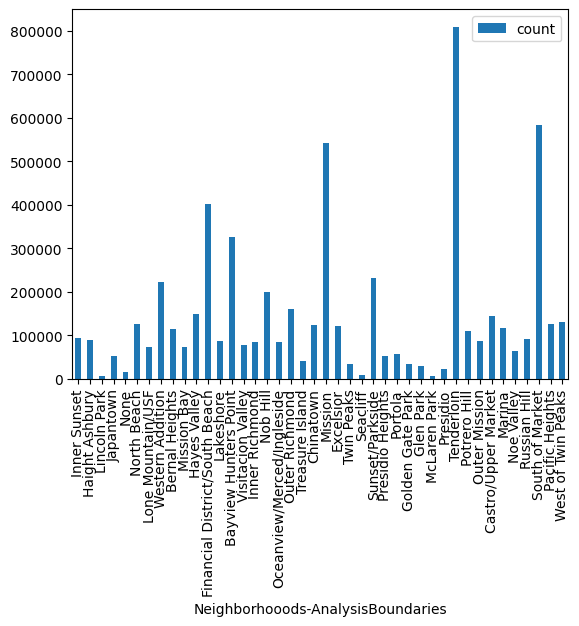

In [38]:
plot_df.set_index("Neighborhooods-AnalysisBoundaries").plot.bar()

In [46]:
# how to count how many cells are not null?
spark.table("calls").agg(
    expr("COUNT(`Neighborhooods-AnalysisBoundaries`)"),
    expr("COUNT(*)"),
).toPandas()

,COUNT(Neighborhooods-AnalysisBoundaries),COUNT(1)
0,6016056,6016056


In [42]:
spark.table("calls").groupby("Neighborhooods-AnalysisBoundaries").count().toPandas()

,Neighborhooods-AnalysisBoundaries,count
0,Inner Sunset,95266
1,Haight Ashbury,89918
2,Lincoln Park,5903
3,Japantown,53161
4,None,16743
5,North Beach,126516
6,Lone Mountain/USF,72502
7,Western Addition,222759
8,Bernal Heights,113744
9,Mission Bay,72477


In [ ]:
# Nested example
# Note: there are CallTypeGroups, each containing CallTypes, containing calls
# for each CallTypeGroup, how many CallTypes are there, how many (avg) calls per CallType

In [47]:
spark.sql("""
SELECT CallTypeGroup, CallType, COUNT(*) as count
FROM calls
GROUP BY CallTypeGroup, CallType
""").toPandas()

,CallTypeGroup,CallType,count
0,None,Elevator / Escalator Rescue,7062
1,None,Marine Fire,222
2,None,Aircraft Emergency,1263
3,None,Confined Space / Structure Collapse,286
4,None,Administrative,306
...,...,...,...
73,Alarm,Watercraft in Distress,14
74,Fire,Train / Rail Fire,10
75,Alarm,Vehicle Fire,13
76,Fire,Administrative,1


In [48]:
spark.sql("""
SELECT CallTypeGroup, COUNT(*) as categories, AVG(count) as avg_per_category
FROM (
    SELECT CallTypeGroup, CallType, COUNT(*) as count
    FROM calls
    GROUP BY CallTypeGroup, CallType
)
GROUP BY CallTypeGroup
""").toPandas()

,CallTypeGroup,categories,avg_per_category
0,Alarm,18,41797.777778
1,None,32,88049.687500
2,Potentially Life-Threatening,5,307467.600000
3,Non Life-threatening,3,258484.000000
4,Fire,20,6665.800000


In [51]:
(spark.table("calls")
 .groupby("CallTypeGroup", "CallType")
 .count()
 .groupby("CallTypeGroup")
 .agg(
     expr("COUNT(*)").alias("categories"),
     expr("AVG(count)").alias("avg_per_category")
 )
).toPandas()

,CallTypeGroup,categories,avg_per_category
0,Alarm,18,41797.777778
1,None,32,88049.687500
2,Potentially Life-Threatening,5,307467.600000
3,Non Life-threatening,3,258484.000000
4,Fire,20,6665.800000


## Lecture Part 3: Joining